# Big Data Analysis Project - Data Exploratory Analysis

### This is a project for Concordia's Bigdata class (SOEN691 UU) by Dr. Tristan Glatard in Winter 2020.
*Team Members:*
- Le, Manh Quoc Dat (Student ID: 40153127)<br />
- Tran, Trong Tuan (Student ID: 40151694)<br />
- Phan, Vu Hong Hai (Student ID: 40154023)<br />
- Zhang, Yefei (Student ID: 40153319)<br />

Main project repository: https://github.com/HongHaiPV/concordia-bigdata-project <br />
Datasource: https://sites.google.com/eng.ucsd.edu/fitrec-project/home <br />
(Jianmo Ni, Larry Muhlstein, Julian McAuley, "Modeling heart rate and activity data for personalized fitness recommendation", in Proc. of the 2019 World Wide Web Conference (WWW'19), San Francisco, US, May. 2019.)

Load data set into spark dataframe:

In [36]:
import os
import sys
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.sql.functions import col
from pyspark.sql.functions import size
from pandas import DataFrame
from IPython.core.interactiveshell import InteractiveShell
import matplotlib
InteractiveShell.ast_node_interactivity = "all" # This helps auto print out the items without explixitly using 'print'

# Initialize a spark session.

conf = pyspark.SparkConf().setMaster("local[*]")
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("BigData Project - Exploratory Analysis") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = './data/endomondoHR.json'
filename_metadata = './data/endomondoMeta.json'
df = spark.read.json(filename_data, mode="DROPMALFORMED")
df_meta = spark.read.json(filename_metadata, mode="DROPMALFORMED")
type(df)

pyspark.sql.dataframe.DataFrame

Shows columns & types:

In [24]:
print('Columns & datatypes:')
dataframe = DataFrame(df.dtypes, columns =['Column Name','Data type'])
dataframe

Columns & datatypes:


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


First description about dataset (this describe function exlcude the columns with list/array) and first 2 data rows:

In [18]:
print('Data describe:')
df.describe().toPandas()
#print('metadata describe:')
#print(df_meta.describe().show())

print('Data fisrt 2 rows:')
df.limit(2).toPandas()
#print('metadata fisrt:')
#print(df_meta.first())

Data describe:


,summary,gender,id,sport,url,userId,PerWorkoutRecordCount
0,count,253020,253020,253020,253020,253020,253020
1,mean,None,3.566244412926132E8,None,None,4619648.939783417,440.84244723737254
2,stddev,None,1.574845634895318E8,None,None,3932877.7296880507,125.16138207242905
3,min,female,99296,aerobics,https://www.endomondo.com/users/10014612/worko...,69,1
4,max,unknown,674008008,yoga,https://www.endomondo.com/users/9991401/workou...,15481421,500


Summarize on users and genders:

In [37]:
print('Summarize on gender:')
gender_user_count = df.select('gender','userId').distinct().groupBy('gender').count().toPandas()
gender_activities_count = df.groupBy('gender').count().toPandas()
#gender_user_count
#gender_activities_count
gender_user_activity_count = gender_user_count.join(gender_activities_count.set_index('gender'), on='gender'
                                                    , how='inner', lsuffix='_gu')
gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']
gender_user_activity_count

Summarize on gender:


,Gender,# of users,Activities (workouts) count
0,unknown,15,1942
1,female,110,15959
2,male,979,235119


Summary on activities:

Activity count:


,Sport (Activity) types
0,49


List of all activities:


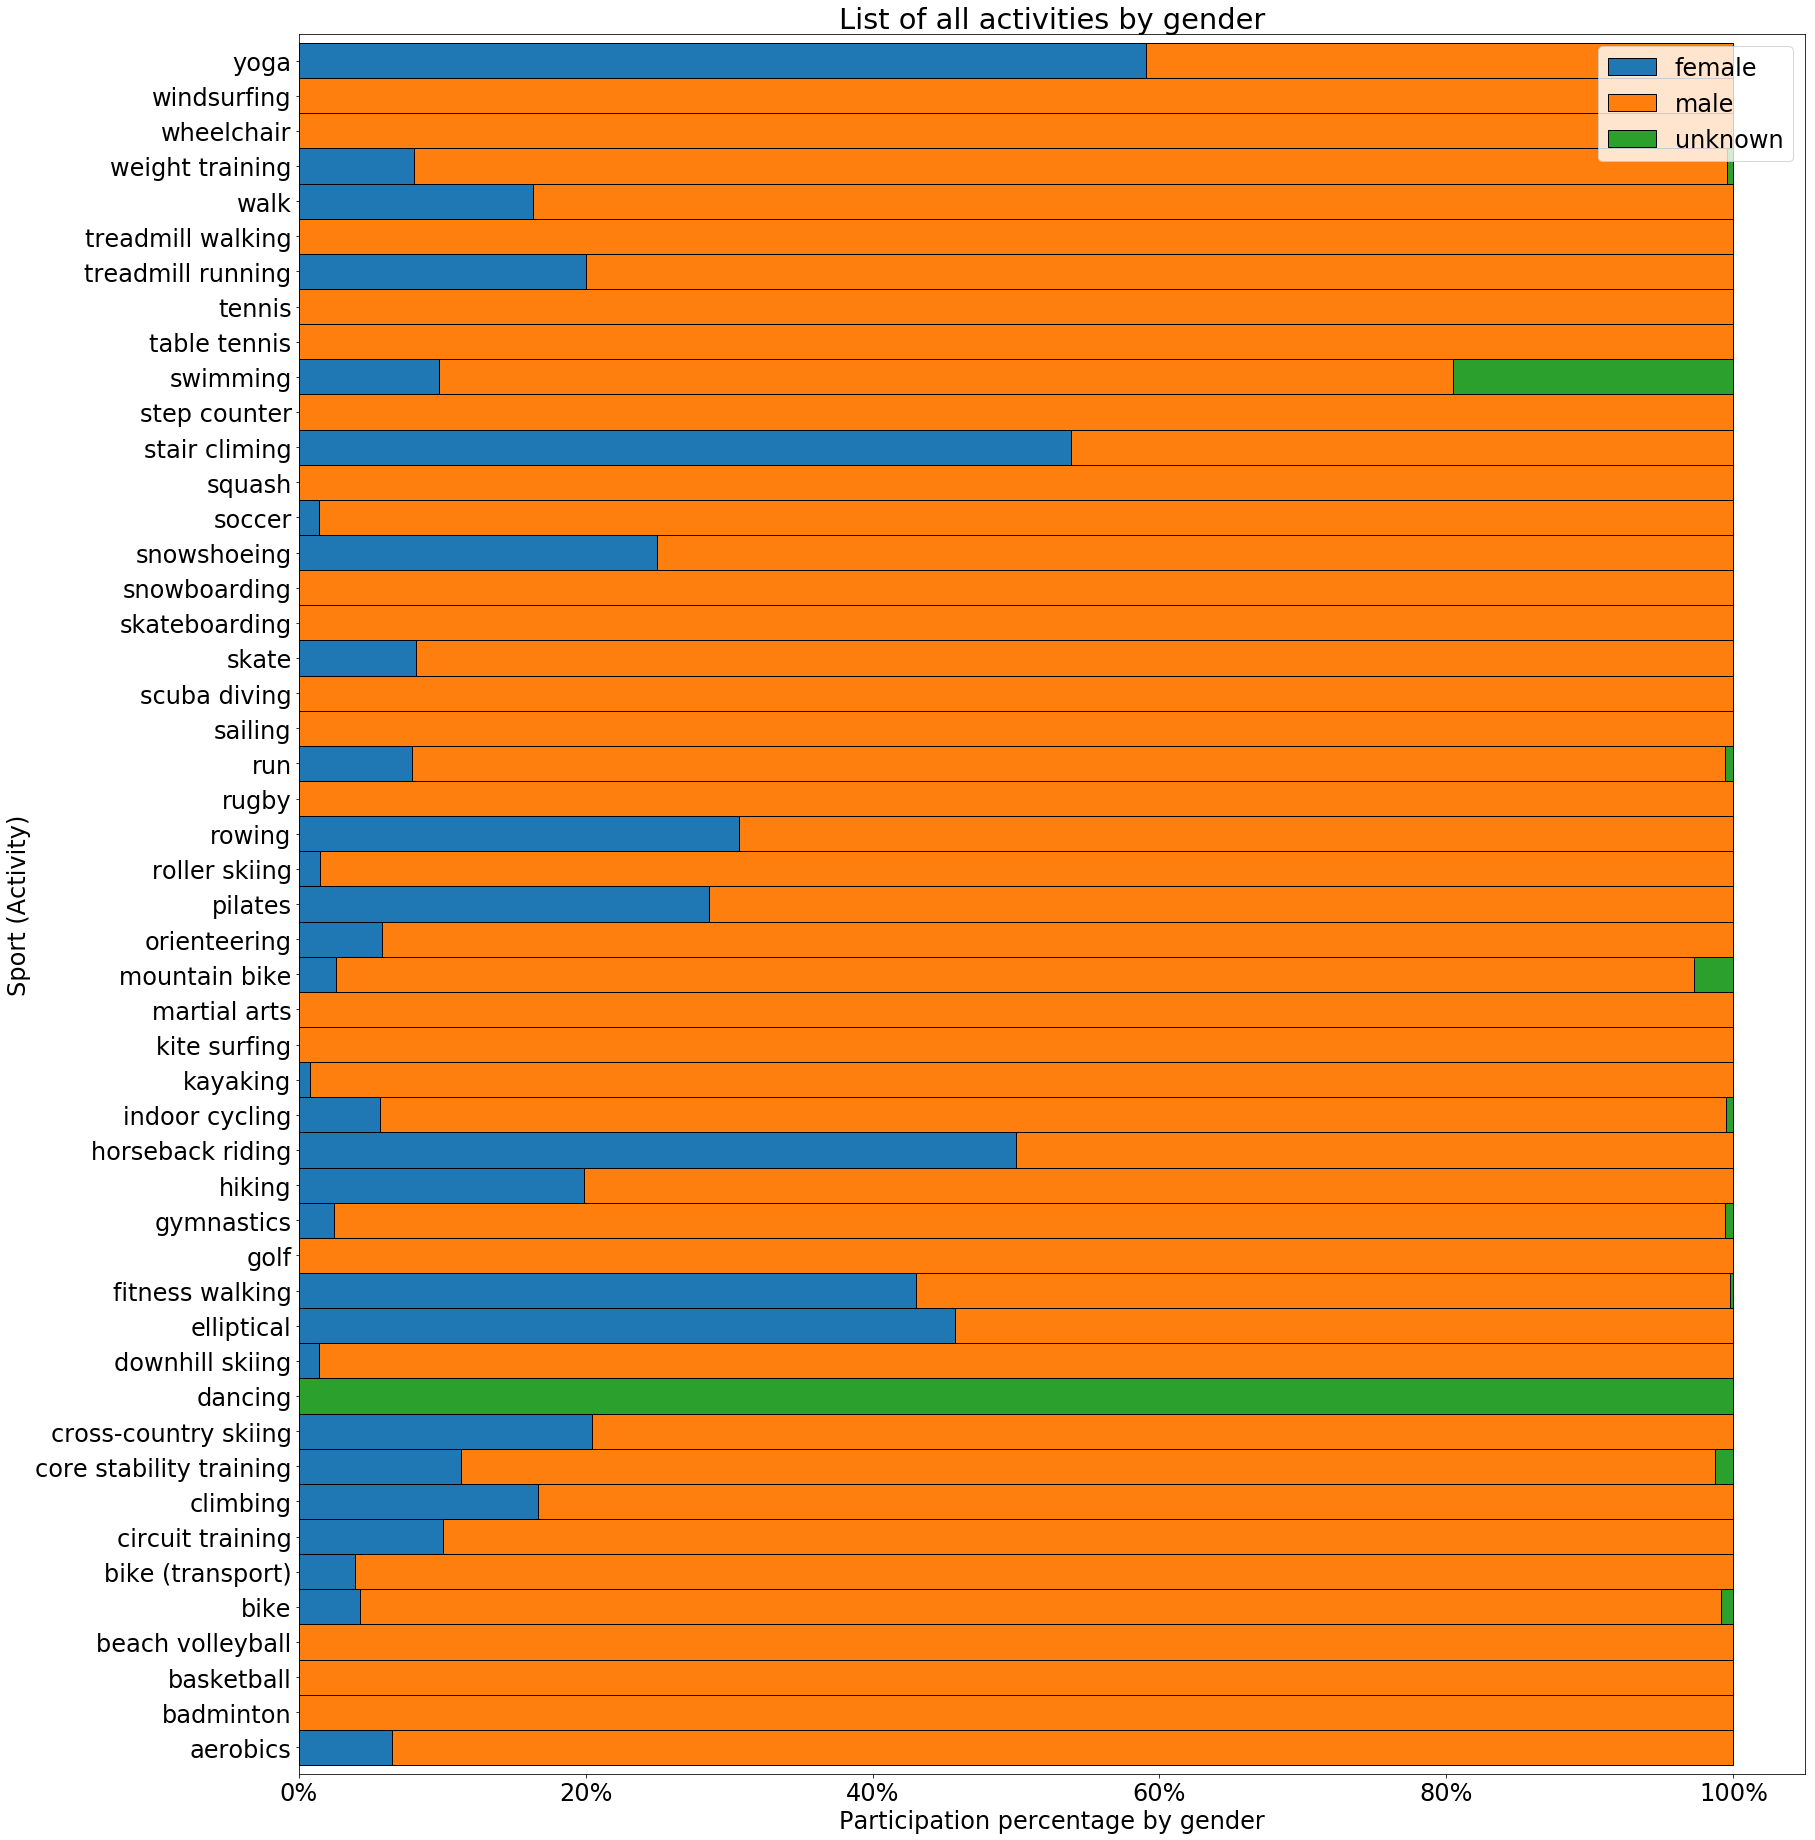

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
#userCount = df.select('userId').distinct().count()
#activities = df.select('sport').distinct()
#activityCount = activities.count()
#TO DO: average workouts by user
#count = DataFrame([[activityCount]] ,columns= ['Sport (Activity) types'])
print('Activity count:')
count
print('List of all activities:')
#activities.toPandas()
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas()
fig = plt.figure(figsize=(27, 32))
grid_size = (1,1)

ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)


# source1: http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot#stacked-bar-plot-with-group-by
# source2: https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c
plot = activities_by_gender.groupby(['sport', 'gender']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1
                , edgecolor='black', ax=ax, title='List of all activities by gender')
a= plt.ylabel('Sport (Activity)')
b= plt.xlabel('Participation percentage by gender')
c= plt.legend(sorted(activities_by_gender['gender'].unique()), loc='upper right')
d= plt.rcParams.update({'font.size': 24})
#plt.axes.xaxis.labelpad = 10
ax = plt.gca()
f = ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [6]:
df = df.withColumn('PerWorkoutRecordCount', size(col('timestamp')))

df.select('userId', 'id', 'sport','PerWorkoutRecordCount')\
   .distinct().orderBy(['userId', 'id']).limit(20).toPandas()


,userId,id,sport,PerWorkoutRecordCount
0,69,20253450,bike,499
1,69,20253456,run,500
2,69,24888428,run,499
3,69,24888434,run,500
4,69,27730553,run,499
5,69,28639037,run,276
6,69,30369221,run,500
7,69,32334585,run,499
8,69,32946380,run,95
9,69,34543589,run,25
